# ddPCR SNP Assay Design

This notebook designs **dual-color hydrolysis probe assays** (e.g., TaqMan) for Droplet Digital PCR (ddPCR) to detect specific Single Nucleotide Polymorphisms (SNPs) or small indels.

## Assay Strategy
For each variant, we design a single pair of primers and two competition probes:
1.  **Common Primers**: Flank the variant site. Amplify both Wild Type (WT) and Mutant (MUT) alleles.
2.  **WT Probe (e.g., VIC/HEX)**: Specifically binds to the Reference allele sequence.
3.  **MUT Probe (e.g., FAM)**: Specifically binds to the Variant allele sequence.

## Workflow
1.  **Load Variants**: Read target variants from a VCF file.
2.  **Sequence Generation**: Extract the Reference sequence and generate the Mutant sequence in silico.
3.  **Design Primers & WT Probe**: Use `primer3` to pick optimal primers and a probe for the Reference sequence.
4.  **Design MUT Probe**: Use `primer3` to pick a compatible probe for the Mutant sequence, constrained by the chosen primers.
5.  **Virtual PCR**: Simulate PCR amplification to verify primers work on both alleles.
6.  **Export**: Save the primer and probe sequences to a CSV file ready for ordering.

In [10]:
# Install dependencies if needed
%pip install primer3-py pysam

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pysam
import primer3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pypcrtool.pcr import InSilicoPCR
from pathlib import Path

# Configuration
VCF_PATH = "../data/vcf/CTC030/CTC030_pre_treatment_KRAS.vcf.gz"
REF_GENOME_PATH = "../data/Homo_sapiens.GRCh38.dna.primary_assembly.fa"
OUTPUT_CSV = "ddpcr_snp_assays.csv"
OUTPUT_DIR = "ddpcr_design_output"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Validation
if not os.path.exists(VCF_PATH):
    print(f"Warning: VCF file not found at {VCF_PATH}")
if not os.path.exists(REF_GENOME_PATH):
    print(f"Warning: Reference genome not found at {REF_GENOME_PATH}")

In [12]:
def get_sequences(chrom, pos, ref, alt, genome_fasta, flank_size=200):
    """
    Generates Reference and Mutant sequences for a variant.
    """
    start = pos - 1 - flank_size
    end = pos - 1 + len(ref) + flank_size
    ref_seq = genome_fasta.fetch(chrom, start, end)
    
    prefix = ref_seq[:flank_size]
    suffix = ref_seq[flank_size + len(ref):]
    mut_seq = prefix + alt + suffix
    target_pos = flank_size
    return ref_seq, mut_seq, target_pos

def design_snp_assay(ref_seq, mut_seq, target_pos, ref_len, alt_len, assay_name="assay"):
    """
    Designs common primers and specific probes for WT and MUT alleles.
    """
    # --- Step 1: Design Primers & WT Probe ---
    seq_args_ref = {
        'SEQUENCE_ID': f"{assay_name}_WT",
        'SEQUENCE_TEMPLATE': ref_seq,
        'SEQUENCE_TARGET': [target_pos, ref_len]
    }
    global_args = {
        'PRIMER_TASK': 'generic',
        'PRIMER_PICK_LEFT_PRIMER': 1,
        'PRIMER_PICK_RIGHT_PRIMER': 1,
        'PRIMER_PICK_INTERNAL_OLIGO': 1,
        'PRIMER_OPT_SIZE': 20,
        'PRIMER_MIN_SIZE': 18,
        'PRIMER_MAX_SIZE': 27,
        'PRIMER_OPT_TM': 60.0,
        'PRIMER_MIN_TM': 58.0,
        'PRIMER_MAX_TM': 62.0,
        'PRIMER_MIN_GC': 30.0,
        'PRIMER_MAX_GC': 70.0,
        'PRIMER_PRODUCT_SIZE_RANGE': [[60, 120]],
        'PRIMER_INTERNAL_OPT_TM': 65.0,
        'PRIMER_INTERNAL_MIN_TM': 63.0,
        'PRIMER_INTERNAL_MAX_TM': 70.0,
        'PRIMER_NUM_RETURN': 1
    }
    try:
        # Use design_primers instead of designPrimers (deprecated)
        res_ref = primer3.bindings.design_primers(seq_args_ref, global_args)
    except Exception as e:
        print(f"  Ref design failed: {e}")
        return None
    if res_ref.get('PRIMER_PAIR_NUM_RETURNED', 0) == 0:
        return None

    fwd_primer = res_ref['PRIMER_LEFT_0_SEQUENCE']
    rev_primer = res_ref['PRIMER_RIGHT_0_SEQUENCE']
    wt_probe = res_ref['PRIMER_INTERNAL_0_SEQUENCE']
    
    # --- Step 2: Design MUT Probe ---
    seq_args_mut = {
        'SEQUENCE_ID': f"{assay_name}_MUT",
        'SEQUENCE_TEMPLATE': mut_seq,
        'SEQUENCE_TARGET': [target_pos, alt_len],
    }
    global_args_mut = global_args.copy()
    global_args_mut['PRIMER_PICK_LEFT_PRIMER'] = 0
    global_args_mut['PRIMER_PICK_RIGHT_PRIMER'] = 0
    global_args_mut['PRIMER_PICK_INTERNAL_OLIGO'] = 1
    
    try:
        res_mut = primer3.bindings.design_primers(seq_args_mut, global_args_mut)
    except Exception as e:
        print(f"  Mut design failed: {e}")
        return {
            'Forward_Primer': fwd_primer,
            'Reverse_Primer': rev_primer,
            'WT_Probe': wt_probe,
            'MUT_Probe': None,
            'Amplicon_Size': res_ref['PRIMER_PAIR_0_PRODUCT_SIZE']
        }

    mut_probe = res_mut.get('PRIMER_INTERNAL_0_SEQUENCE', None)
    return {
        'Forward_Primer': fwd_primer,
        'Reverse_Primer': rev_primer,
        'WT_Probe': wt_probe,
        'MUT_Probe': mut_probe,
        'Amplicon_Size': res_ref['PRIMER_PAIR_0_PRODUCT_SIZE']
    }

In [13]:
def visualize_ddpcr_gel(fwd_primer, rev_primer, wt_fasta_path, mut_fasta_path, assay_name, output_dir):
    """
    Simulates PCR and generates a gel image for ddPCR (Common Primers).
    Shows amplification on both WT and MUT templates.
    """
    reactions = [
        ("Common Primers + WT Template", fwd_primer, rev_primer, wt_fasta_path),
        ("Common Primers + MUT Template", fwd_primer, rev_primer, mut_fasta_path),
    ]
    
    pcr_results = {}
    print(f"Running Virtual PCR for {assay_name}...")
    
    for label, fwd, rev, template in reactions:
        pcr = InSilicoPCR(forward_primer=fwd, reverse_primer=rev, sequence_file=str(template))
        try:
            products = pcr.perform_pcr()
            product_size = None
            
            # Robust parsing logic from pcr_visualization.py
            if products and len(products) > 0:
                first_product = products[0]
                if isinstance(first_product, dict) and "amplicon" in first_product:
                    amplicon = first_product["amplicon"]
                    if isinstance(amplicon, str):
                        product_size = len(amplicon)
                    elif isinstance(amplicon, (list, tuple)):
                        product_size = len(amplicon)
                    elif isinstance(amplicon, (int, float)):
                        product_size = int(amplicon)
                elif isinstance(first_product, tuple):
                    sequence_candidate = None
                    for element in first_product:
                        if isinstance(element, str):
                            sequence_candidate = element
                            break
                    if sequence_candidate is not None:
                        product_size = len(sequence_candidate)
                    else:
                        for element in first_product:
                            if isinstance(element, (int, np.integer)) and element > 0:
                                product_size = int(element)
                                break
                elif isinstance(first_product, str):
                    product_size = len(first_product)
            
            if product_size:
                pcr_results[label] = product_size
                print(f"  {label}: {product_size} bp")
            else:
                pcr_results[label] = None
                print(f"  {label}: Product found but size unknown (Parsing failed)")
                
        except Exception as e:
            print(f"  {label}: Error {e}")
            pcr_results[label] = None

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(4, 6))
    ax.set_facecolor("#e0e0e0")
    fig.patch.set_facecolor("#e0e0e0")
    
    # Ladder
    marker_lane_x = 1.0
    marker_sizes = [50, 100, 150, 200, 300]
    for size in marker_sizes:
        y = np.log10(size) * 2.0
        rect = patches.Rectangle((marker_lane_x - 0.15, y - 0.01), 0.3, 0.02, facecolor="black", alpha=0.9)
        ax.add_patch(rect)
        ax.text(marker_lane_x - 0.3, y, f"{size}", ha="right", va="center", fontsize=8)
    ax.text(marker_lane_x, 5.5, "Ladder", ha="center", va="bottom", fontsize=9)

    # Lanes
    lane_x_positions = [2.0, 3.0]
    for i, (label, size) in enumerate(pcr_results.items()):
        x = lane_x_positions[i]
        # Well
        ax.add_patch(patches.Rectangle((x - 0.2, 5.2), 0.4, 0.1, facecolor="#b0b0b0", edgecolor="black"))
        # Label
        short_label = "WT Temp" if "WT" in label else "MUT Temp"
        ax.text(x, 5.5, short_label, ha="center", va="bottom", fontsize=9)
        
        if size:
            y = np.log10(size) * 2.0
            ax.add_patch(patches.Rectangle((x - 0.25, y - 0.02), 0.5, 0.04, facecolor="black", alpha=0.95))
            ax.text(x, y-0.15, f"{size}bp", ha="center", va="top", fontsize=7)

    ax.set_xlim(0, 4.0)
    ax.set_ylim(3.0, 6.0)
    ax.axis('off')
    
    out_path = os.path.join(output_dir, f"{assay_name}_gel.png")
    plt.savefig(out_path, dpi=150, bbox_inches='tight', facecolor="#e0e0e0")
    plt.close()
    return out_path

Processing ../data/vcf/CTC030/CTC030_pre_treatment_KRAS.vcf.gz...

Designing for 12_25205716_A_T...
  -> Design failed

Designing for 12_25205728_CTTTTTTTT_CTTTTTT...
  -> Design failed

Designing for 12_25207204_T_C...
Running Virtual PCR for 12_25207204_T_C...
  Common Primers + WT Template: 119 bp
  Common Primers + MUT Template: 119 bp
  -> Success. Gel image generated.


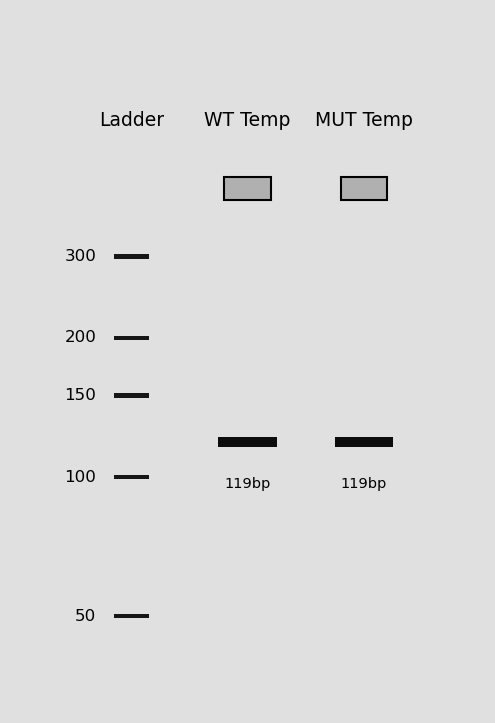


Designing for 12_25208712_T_C...
Running Virtual PCR for 12_25208712_T_C...
  Common Primers + WT Template: 119 bp
  Common Primers + MUT Template: 119 bp
  -> Success. Gel image generated.

Designing for 12_25209531_G_A...
Running Virtual PCR for 12_25209531_G_A...
  Common Primers + WT Template: 118 bp
  Common Primers + MUT Template: 118 bp
  -> Success. Gel image generated.

Designing for 12_25209618_A_C...
  -> Design failed

Designing for 12_25209843_A_G...
  -> Design failed

Designing for 12_25214904_A_C...
Running Virtual PCR for 12_25214904_A_C...
  Common Primers + WT Template: 101 bp
  Common Primers + MUT Template: 101 bp
  -> Success. Gel image generated.

Designing for 12_25215150_T_C...
  -> Design failed

Designing for 12_25218970_C_T...
Running Virtual PCR for 12_25218970_C_T...
  Common Primers + WT Template: 112 bp
  Common Primers + MUT Template: 112 bp
  -> Success. Gel image generated.

Designing for 12_25225092_G_A...
  -> Design failed

Designing for 12_252252

In [14]:
# Main Execution
results = []

if os.path.exists(VCF_PATH) and os.path.exists(REF_GENOME_PATH):
    vcf_in = pysam.VariantFile(VCF_PATH)
    genome = pysam.FastaFile(REF_GENOME_PATH)
    
    print(f"Processing {VCF_PATH}...")
    
    for rec in vcf_in.fetch():
        chrom = rec.chrom
        pos = rec.pos
        ref = rec.ref
        alt = rec.alts[0] if rec.alts else None
        if not alt: continue
            
        variant_id = f"{chrom}_{pos}_{ref}_{alt}"
        print(f"\nDesigning for {variant_id}...")
        
        # 1. Get Sequences
        ref_seq, mut_seq, target_pos = get_sequences(chrom, pos, ref, alt, genome)
        
        # 2. Design Assay
        assay = design_snp_assay(ref_seq, mut_seq, target_pos, len(ref), len(alt), assay_name=variant_id)
        
        if assay:
            # 3. Virtual PCR & Visualization
            # Save temp FASTA for InSilicoPCR
            wt_fasta = os.path.join(OUTPUT_DIR, f"{variant_id}_WT.fasta")
            mut_fasta = os.path.join(OUTPUT_DIR, f"{variant_id}_MUT.fasta")
            with open(wt_fasta, 'w') as f: f.write(f">WT\n{ref_seq}\n")
            with open(mut_fasta, 'w') as f: f.write(f">MUT\n{mut_seq}\n")
            
            gel_img = visualize_ddpcr_gel(
                assay['Forward_Primer'], assay['Reverse_Primer'], 
                wt_fasta, mut_fasta, variant_id, OUTPUT_DIR
            )
            
            row = {
                'VariantID': variant_id,
                'Forward_Primer': assay['Forward_Primer'],
                'Reverse_Primer': assay['Reverse_Primer'],
                'WT_Probe_VIC': assay['WT_Probe'],
                'MUT_Probe_FAM': assay['MUT_Probe'],
                'Amplicon_Size': assay['Amplicon_Size'],
                'Gel_Image': gel_img
            }
            results.append(row)
            print("  -> Success. Gel image generated.")
            
            # Display the first gel image in notebook
            if len(results) == 1:
                from IPython.display import Image, display
                display(Image(filename=gel_img))
        else:
            print("  -> Design failed")
            
    vcf_in.close()
    genome.close()
    
    if results:
        df = pd.DataFrame(results)
        df.to_csv(OUTPUT_CSV, index=False)
        print(f"\nSaved {len(df)} assays to {OUTPUT_CSV}")
    else:
        print("No assays generated.")
else:
    print("Input files missing.")